# Lab 5 - Clasificacion de imagenes: piedra, papel o tijeras.

El objetivo de este laboratorio es entrenar un clasificador de imagenes para el siguiente dataset:

https://public.roboflow.com/classification/rock-paper-scissors/

## Preparación del entorno.

Si no estamos parados en el repo, clonar y cd al repo. Esto nos permite usar el mismo notebook tanto local como en Google Colab.

In [1]:
import os

REPO_NAME = "lab5"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/FCEIA-AAII/{REPO_NAME}.git
  os.chdir(REPO_NAME)


Cloning into 'lab5'...
remote: Enumerating objects: 2942, done.
remote: Counting objects: 100% (2942/2942), done.
remote: Compressing objects: 100% (2941/2941), done.
remote: Total 2942 (delta 1), reused 2938 (delta 0), pack-reused 0
Receiving objects: 100% (2942/2942), 15.17 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (1/1), done.


Importar librerías

In [2]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
import matplotlib.pyplot as plt
from PIL import Image

Establecer GPU por defecto en caso de estar disponible.

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


Cargar dataset:

In [4]:
# Directorio de los datos
DATA_DIRECTORY = Path("rock-paper-scissors/dataset")
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 2892 files belonging to 3 classes.
Using 2314 files for training.
Found 2892 files belonging to 3 classes.
Using 578 files for validation.


Inspeccionar las clases:

In [5]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['paper', 'rock', 'scissors']


Visualizar los datos:

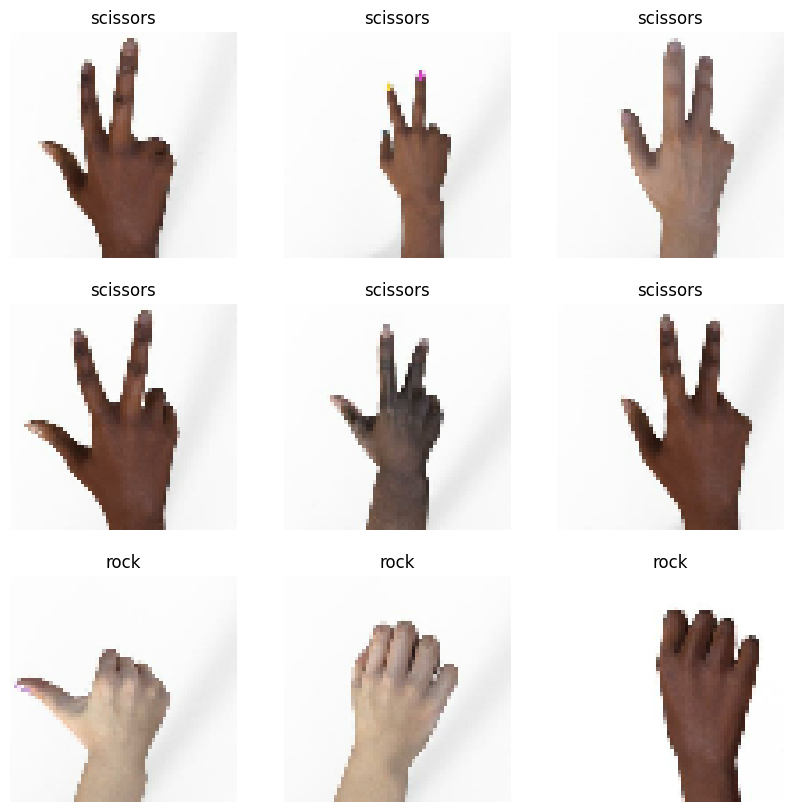

In [6]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

Definir la arquitectura de la red:

In [7]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

Construir el modelo:

In [8]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


Resumen del modelo:

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_translation (Random  (None, 64, 64, 3)         0         
 Translation)                                                    
                                                                 
 random_contrast (RandomCon  (None, 64, 64, 3)         0         
 trast)                                                      

Entrenar el modelo:

In [10]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
37/37 [==============================] - 10s 65ms/step - loss: 1.0798 - accuracy: 0.3941 - val_loss: 1.0219 - val_accuracy: 0.3599
Epoch 2/30
37/37 [==============================] - 1s 31ms/step - loss: 0.9252 - accuracy: 0.5696 - val_loss: 0.6715 - val_accuracy: 0.6574
Epoch 3/30
37/37 [==============================] - 1s 30ms/step - loss: 0.6347 - accuracy: 0.7498 - val_loss: 0.2418 - val_accuracy: 0.9498
Epoch 4/30
37/37 [==============================] - 1s 32ms/step - loss: 0.4641 - accuracy: 0.8237 - val_loss: 0.5248 - val_accuracy: 0.6817
Epoch 5/30
37/37 [==============================] - 1s 31ms/step - loss: 0.3979 - accuracy: 0.8453 - val_loss: 0.1566 - val_accuracy: 0.9758
Epoch 6/30
37/37 [==============================] - 1s 31ms/step - loss: 0.2785 - accuracy: 0.8989 - val_loss: 0.1305 - val_accuracy: 0.9758
Epoch 7/30
37/37 [==============================] - 1s 32ms/step - loss: 0.2270 - accuracy: 0.9188 - val_loss: 0.1809 - val_accuracy: 0.9170
Epoch 8/30
3

Visualizar resultados de entrenamiento:

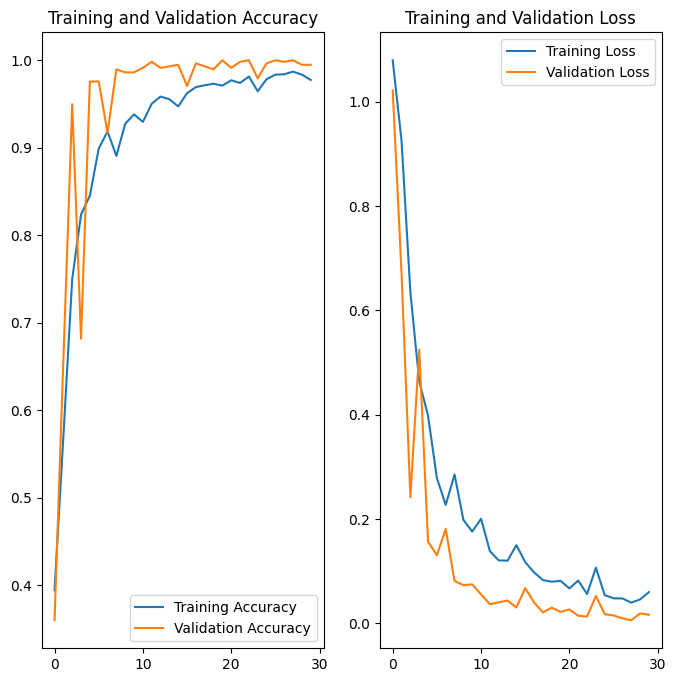

In [11]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predecir en nuevas imagenes:

1/1 [==============================] - 0s 27ms/step


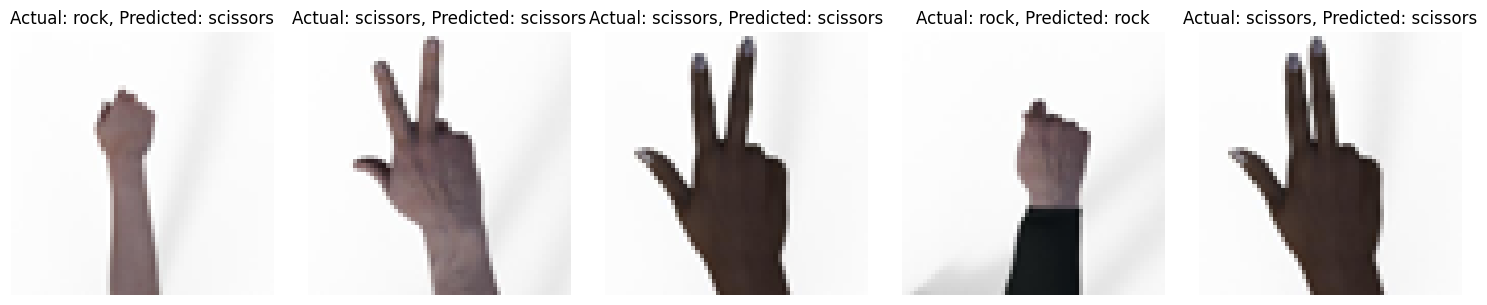

In [12]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Test images directory
TEST_IMAGES_DIRECTORY = Path("rock-paper-scissors/test-dataset")

# Get list of test image paths
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*.jpg"))

# Display 5 images with their actual and predicted classes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocess the image
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Perform prediction
    prediction = model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    actual_class = ""
    if image_path.name.startswith("paper"):
        actual_class = "paper"
    elif image_path.name.startswith("rock"):
        actual_class = "rock"
    elif image_path.name.startswith("scissors"):
        actual_class = "scissors"

    # Display result
    ax.set_title(f"Actual: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()